# Imports

In [1]:
import yfinance as yf
import pandas as pd
from darts import TimeSeries
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


from darts.timeseries import concatenate
from darts.dataprocessing.transformers import StaticCovariatesTransformer
from darts.dataprocessing.transformers import Scaler
from darts.models.forecasting.random_forest import RandomForest
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel, TFTModel, NBEATSModel, LinearRegressionModel, TransformerModel, TCNModel
from darts.metrics import mape, mae, r2_score, rmse, smape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression, GaussianLikelihood
from darts.utils.missing_values import fill_missing_values, missing_values_ratio
from darts.utils.model_selection import train_test_split
import darts.utils.statistics as darts_stats

from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

from models.SCINet.SCINet_train import Exp_financial

# Global Variables

In [2]:
TICKER = 'AAPL'
TARGET = 'Returns' # 'Close'
FEATURES = ['High', 'Low', 'Open']
RANDOM = 101
INPUT_CHUNK = 25

OUTPUT_CHUNK = 5
START=1200
RETRAIN=True
LAST=False
RESET=False

# Helper functions

In [3]:
def inverse_func(transformer, pred, true):
    return transformer.inverse_transform(pred), transformer.inverse_transform(true)

def error_print(true_inversed, pred_inversed):
    error_mape = mape(
        actual_series=true_inversed,
        pred_series=pred_inversed,
        intersect=True,
    )

    error_mae = mae(
        actual_series=true_inversed,
        pred_series=pred_inversed,
        intersect=True,
    )

    error_r2 = r2_score(
        actual_series=true_inversed,
        pred_series=pred_inversed,
        intersect=True,
    )

    error_rmse = rmse(
        actual_series=true_inversed,
        pred_series=pred_inversed,
        intersect=True,
    )

    error_smape = smape(
        actual_series=true_inversed,
        pred_series=pred_inversed,
        intersect=True,
    )

    print(
        f"MAPE error is {error_mape:.5f} %",
        f"\nMAE error is {error_mae:.5f} %",
        f"\nR2 error is {error_r2:.5f} %",
        f"\nRMSE error is {error_rmse:.5f} %",
        f"\nSMAPE error is {error_smape:.5f} %"
        )

# Data Load

In [4]:
def load_data():
    id_to_ticker_path = "Datasets/kaggle/Company_Tweet.csv"
    ticker_to_name_path = "Datasets/kaggle/Company.csv"

    tickers_df = pd.read_csv(id_to_ticker_path)
    company_name_df = pd.read_csv(ticker_to_name_path)
    tickers = company_name_df.ticker_symbol.tolist()
    # tickers.append('AMD')
    # tickers.append('BAC')

    market_data = yf.download((' ').join(tickers), start="2014-12-31", end="2020-01-01", group_by = 'ticker')

    returns = pd.DataFrame()

    for ticker in market_data.columns.levels[0]:
        returns[ticker] = market_data[ticker].Close.pct_change()

    # market_data['Returns'] = None
    # market_data['Returns'] = returns.values.flatten()

    # for ticker in market_data.columns.levels[0]:
    #     returns[ticker] = market_data[ticker].Close.shift(-1).dropna()

    market_data = market_data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)

    market_data = market_data.dropna()
    market_data = market_data.reset_index()

    market_data.to_csv('Datasets/market/market.csv', index=False)

    return market_data, returns

In [5]:
data, returns = load_data()
data['Returns'] = returns.values.flatten()
data.dropna(inplace=True, axis=0)
data.reset_index(drop=True, inplace=True)

data['order'] = None

for i, j in itertools.product(range(0, len(data), data.nunique().Ticker), range(6)):
    data.loc[i+j, 'order'] = i and int(i / 6) or 0

data.order = data.order.astype('int')

data = data[data.Ticker == TICKER]

data

[*********************100%***********************]  6 of 6 completed


,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,Returns,order
0,2015-01-02,AAPL,24.603209,27.332500,27.860001,26.837500,27.847500,212818400,-0.009513,0
6,2015-01-05,AAPL,23.910091,26.562500,27.162500,26.352501,27.072500,257142000,-0.028172,1
12,2015-01-06,AAPL,23.912342,26.565001,26.857500,26.157499,26.635000,263188400,0.000094,2
18,2015-01-07,AAPL,24.247650,26.937500,27.049999,26.674999,26.799999,160423600,0.014022,3
24,2015-01-08,AAPL,25.179296,27.972500,28.037500,27.174999,27.307501,237458000,0.038422,4
...,...,...,...,...,...,...,...,...,...,...
7518,2019-12-24,AAPL,69.623230,71.067497,71.222504,70.730003,71.172501,48478800,0.000951,1253
7524,2019-12-26,AAPL,71.004585,72.477501,72.495003,71.175003,71.205002,93121200,0.019840,1254
7530,2019-12-27,AAPL,70.977631,72.449997,73.492500,72.029999,72.779999,146266000,-0.000379,1255
7536,2019-12-30,AAPL,71.398888,72.879997,73.172501,71.305000,72.364998,144114400,0.005935,1256


In [6]:
# import numpy as np

# series_multi = TimeSeries.from_group_dataframe(
#     data,
#     time_col="order",
#     group_cols="Ticker",  # individual time series are extracted by grouping `df` by `group_cols`
#     static_cols=[],
#     value_cols=[
#         "Close"
#     ],  # optionally, specify the time varying columns which are extracted
# )

# df = pd.DataFrame([])
# for i in range(len(series_multi)):
#     name = series_multi[i].static_covariates['Ticker'][0]
#     vals = series_multi[i].univariate_values()
#     df[name] = vals.tolist()

# np.savetxt('np.txt', df.values, fmt='%.5f', delimiter=',')

# Data preprocessing

## Timeseries init

In [7]:
series = TimeSeries.from_dataframe(
    df=data,
    time_col='Date',
    value_cols=[
        'Adj Close', 
        'Close', 
        'High', 
        'Low', 
        'Open', 
        'Volume',
        'Returns'
        ],
    freq='B',
    fill_missing_dates=True
)

In [8]:
len(data), len(series)

(1258, 1303)

In [9]:
missing_values_ratio(series) * 100

3.453568687643899

In [10]:
df = series.pd_dataframe()

In [11]:
df[df.isna().any(axis=1)][:10]

component,Adj Close,Close,High,Low,Open,Volume,Returns
Date,,,,,,,
2015-01-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-11-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Fill missng values

In [12]:
series = fill_missing_values(
    series,
    method='ffill',
    limit_direction='forward'
    )

In [13]:
df = series.pd_dataframe()

In [14]:
df.iloc[10]

component
Adj Close    2.385158e+01
Close        2.649750e+01
High         2.689500e+01
Low          2.630000e+01
Open         2.675750e+01
Volume       3.140532e+08
Returns     -7.770098e-03
Name: 2015-01-16 00:00:00, dtype: float64

In [15]:
df.iloc[11]

component
Adj Close    2.385158e+01
Close        2.649750e+01
High         2.689500e+01
Low          2.630000e+01
Open         2.675750e+01
Volume       3.140532e+08
Returns     -7.770098e-03
Name: 2015-01-19 00:00:00, dtype: float64

## Add holidays

In [16]:
series = series.add_holidays(country_code='US')

In [17]:
missing_values_ratio(series)

0.0

## Data split, scaling, covariates

In [18]:
series.columns, series.freq, series.is_deterministic

(Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Returns',
        'holidays'],
       dtype='object', name='component'),
 <BusinessDay>,
 True)

In [19]:
train, val = series.split_after(0.85)
val, test = val.split_after(0.97)

MinMax Scaler

In [20]:
transformer_minmax_target = Scaler()
transformer_minmax_cov = Scaler()

train_minmax = transformer_minmax_target.fit_transform(train[TARGET])
train_minmax_cov = transformer_minmax_cov.fit_transform(train[FEATURES])
train_future_cov = train['holidays']

val_minmax = transformer_minmax_target.transform(val[TARGET])
val_minmax_cov = transformer_minmax_cov.transform(val[FEATURES])
val_future_cov = val['holidays']

test_minmax = transformer_minmax_target.transform(test[TARGET])
test_minmax_cov = transformer_minmax_cov.transform(test[FEATURES])
test_future_cov = test['holidays']

series_minmax = transformer_minmax_target.transform(series[TARGET])
series_minmax_cov = transformer_minmax_cov.transform(series[FEATURES])
series_future_cov = series['holidays']

Standard Scaler

In [251]:
transformer_standard_target = Scaler(StandardScaler())
transformer_standard_cov = Scaler(StandardScaler())

train_standard = transformer_standard_target.fit_transform(train[TARGET])
train_standard_cov = transformer_standard_cov.fit_transform(train[FEATURES])

val_standard = transformer_standard_target.transform(val[TARGET])
val_standard_cov = transformer_standard_cov.transform(val[FEATURES])

test_standard = transformer_standard_target.transform(test[TARGET])
test_standard_cov = transformer_standard_cov.transform(test[FEATURES])

series_standard = transformer_standard_target.transform(series[TARGET])
series_standard_cov = transformer_standard_cov.transform(series[FEATURES])

# Models Darts

## Variables

In [252]:
# BlockRNNModel
BLOCK_RNN_EPOCHS=60
BLOCK_RNN_MODEL='LSTM'
checkpoint = ModelCheckpoint(monitor="val_loss")
# TFTModel
TFT_EPOCHS=40

## BlockRNNModel MinMax Raw

In [23]:
try:
  model = BlockRNNModel.load_from_checkpoint("BlockRNNModel_minmax", best=True)
except ValueError:
  block_RNN_model = BlockRNNModel(
    input_chunk_length=INPUT_CHUNK,
    output_chunk_length=OUTPUT_CHUNK,
    n_epochs=BLOCK_RNN_EPOCHS,
    model=BLOCK_RNN_MODEL,
    random_state=RANDOM,
    save_checkpoints=True,
    force_reset=RESET,
    model_name="BlockRNNModel_minmax",
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0],
      "enable_progress_bar": False,
      "callbacks": [checkpoint]
    }
  )

  block_RNN_model.fit(
    series=train_minmax,
    past_covariates=train_minmax_cov,
    # future_covariates=train_future_cov,
    val_series=val_minmax,
    val_past_covariates=val_minmax_cov,
    # val_future_covariates=val_future_cov,
    verbose=False
  )

  model = BlockRNNModel.load_from_checkpoint("BlockRNNModel_minmax", best=True)

In [ ]:
block_RNN_model_historical = model.historical_forecasts(
    series=series_minmax,
    past_covariates=series_minmax_cov,
    # future_covariates=series_future_cov,
    train_length=INPUT_CHUNK+OUTPUT_CHUNK,
    start=START,
    forecast_horizon=OUTPUT_CHUNK,
    stride=OUTPUT_CHUNK,
    retrain=RETRAIN,
    last_points_only=LAST,
    verbose=True,
)

MAPE error is 2.60036 % 
MAE error is 1.48485 % 
R2 error is 0.90420 % 
RMSE error is 1.99989 % 
SMAPE error is 2.64036 %


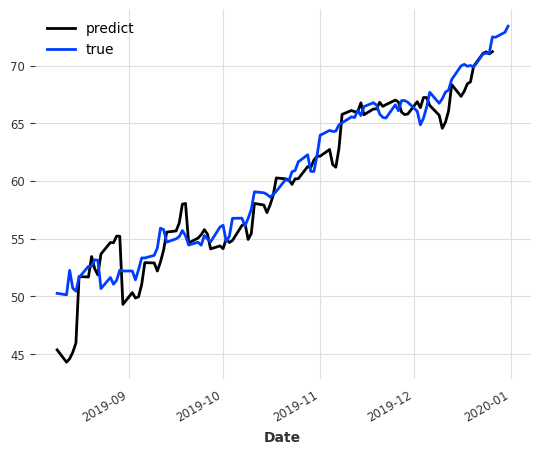

In [25]:
pred_inversed, true_inversed = inverse_func(
    transformer=transformer_minmax_target,
    pred=concatenate(block_RNN_model_historical),
    true=series_minmax
)

pred_inversed.plot(label='predict')
true_inversed[START:].plot(label='true')

error_print(true_inversed, pred_inversed)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
b:\HSE_Masters\.conda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


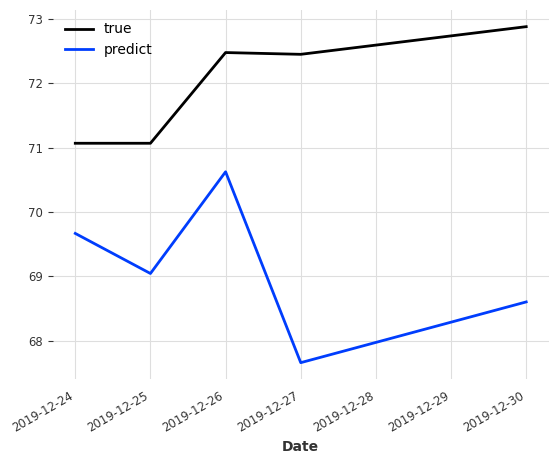

In [26]:
model = BlockRNNModel.load_from_checkpoint("BlockRNNModel_minmax", best=True)

prediction = model.predict(
    n=OUTPUT_CHUNK,
    series=val_minmax,
    past_covariates=val_minmax_cov,
    # future_covariates=val_future_cov,
)

transformer_minmax_target.inverse_transform(test_minmax)[:OUTPUT_CHUNK].plot(label='true')
transformer_minmax_target.inverse_transform(prediction).plot(label='predict')

## BlockRNNModel MinMax Optimized

In [27]:
try:
  model = BlockRNNModel.load_from_checkpoint("BlockRNNModel_minmax_optimized_", best=True)
except ValueError:
  block_RNN_model = BlockRNNModel(
    input_chunk_length=INPUT_CHUNK,
    output_chunk_length=OUTPUT_CHUNK,
    n_epochs=60,
    model='GRU',
    n_rnn_layers=3,
    random_state=RANDOM,
    save_checkpoints=True,
    force_reset=True, # Reset
    model_name="BlockRNNModel_minmax_optimized",
    dropout=0.2,
    hidden_dim=50,
    batch_size=16,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0],
      "enable_progress_bar": False,
      "callbacks": [checkpoint]
    }
  )

  block_RNN_model.fit(
    series=train_minmax,
    past_covariates=train_minmax_cov,
    # future_covariates=train_future_cov,
    val_series=val_minmax,
    val_past_covariates=val_minmax_cov,
    # val_future_covariates=val_future_cov,
    verbose=False,
    max_samples_per_ts=2
  )

  model = BlockRNNModel.load_from_checkpoint("BlockRNNModel_minmax_optimized", best=True)
  # model = block_RNN_model

ValueError: Could not find base model save file `_model.pth.tar` in b:\HSE_Masters\darts_logs\BlockRNNModel_minmax_optimized_.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
b:\HSE_Masters\.conda\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:611: UserWarning: Checkpoint directory b:\HSE_Masters\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
block_RNN_model_historical = model.historical_forecasts(
    series=series_minmax,
    past_covariates=series_minmax_cov,
    # future_covariates=series_future_cov,
    train_length=INPUT_CHUNK+OUTPUT_CHUNK,
    start=START,
    forecast_horizon=OUTPUT_CHUNK,
    stride=OUTPUT_CHUNK,
    retrain=RETRAIN,
    last_points_only=LAST,
    verbose=True,
)

MAPE error is 2.27748 % 
MAE error is 1.37148 % 
R2 error is 0.93480 % 
RMSE error is 1.64979 % 
SMAPE error is 2.30752 %


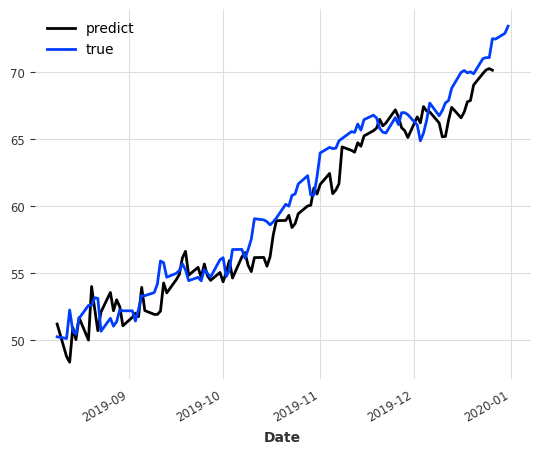

In [29]:
pred_inversed, true_inversed = inverse_func(
    transformer=transformer_minmax_target,
    pred=concatenate(block_RNN_model_historical),
    true=series_minmax
)

pred_inversed.plot(label='predict')
true_inversed[START:].plot(label='true')

error_print(true_inversed, pred_inversed)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


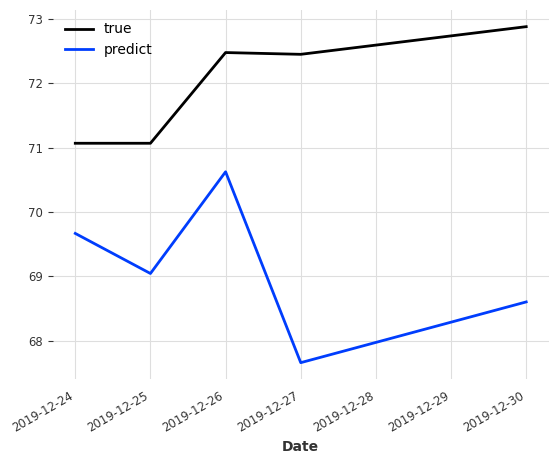

In [30]:
model = BlockRNNModel.load_from_checkpoint("BlockRNNModel_minmax", best=True)

prediction = model.predict(
    n=OUTPUT_CHUNK,
    series=val_minmax,
    past_covariates=val_minmax_cov,
    # future_covariates=val_future_cov,
)

transformer_minmax_target.inverse_transform(test_minmax)[:OUTPUT_CHUNK].plot(label='true')
transformer_minmax_target.inverse_transform(prediction).plot(label='predict')

## BlockRNNModel MinMax Optimized Predict Returns

In [253]:
try:
  model = BlockRNNModel.load_from_checkpoint("BlockRNNModel_minmax_optimized_returns", best=True)
except ValueError:
  block_RNN_model = BlockRNNModel(
    input_chunk_length=INPUT_CHUNK,
    output_chunk_length=OUTPUT_CHUNK,
    n_epochs=60,
    model='GRU',
    n_rnn_layers=3,
    random_state=RANDOM,
    save_checkpoints=True,
    force_reset=True, # Reset
    model_name="BlockRNNModel_minmax_optimized_returns",
    dropout=0.2,
    hidden_dim=50,
    batch_size=16,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0],
      "enable_progress_bar": False,
      "callbacks": [checkpoint]
    }
  )

  block_RNN_model.fit(
    series=train_minmax,
    past_covariates=train_minmax_cov,
    # future_covariates=train_future_cov,
    val_series=val_minmax,
    val_past_covariates=val_minmax_cov,
    # val_future_covariates=val_future_cov,
    verbose=False,
    max_samples_per_ts=2
  )

  model = BlockRNNModel.load_from_checkpoint("BlockRNNModel_minmax_optimized_returns", best=True)
  # model = block_RNN_model

ValueError: Could not find base model save file `_model.pth.tar` in b:\HSE_Masters\darts_logs\BlockRNNModel_minmax_optimized_returns.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
block_RNN_model_historical = model.historical_forecasts(
    series=series_minmax,
    past_covariates=series_minmax_cov,
    # future_covariates=series_future_cov,
    train_length=INPUT_CHUNK+OUTPUT_CHUNK,
    start=START,
    forecast_horizon=OUTPUT_CHUNK,
    stride=OUTPUT_CHUNK,
    retrain=RETRAIN,
    last_points_only=LAST,
    verbose=True,
)

MAPE error is 1432.41671 % 
MAE error is 0.01420 % 
R2 error is -1.00896 % 
RMSE error is 0.01924 % 
SMAPE error is 128.54726 %


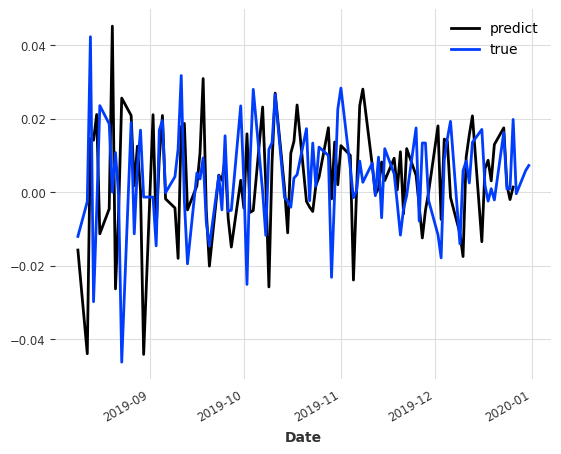

In [255]:
pred_inversed, true_inversed = inverse_func(
    transformer=transformer_minmax_target,
    pred=concatenate(block_RNN_model_historical),
    true=series_minmax
)

pred_inversed.plot(label='predict')
true_inversed[START:].plot(label='true')

error_print(true_inversed, pred_inversed)

MAPE error is 185.90239 % 
MAE error is 0.06656 % 
R2 error is -0.48142 % 
RMSE error is 0.08104 % 
SMAPE error is 60.12408 %


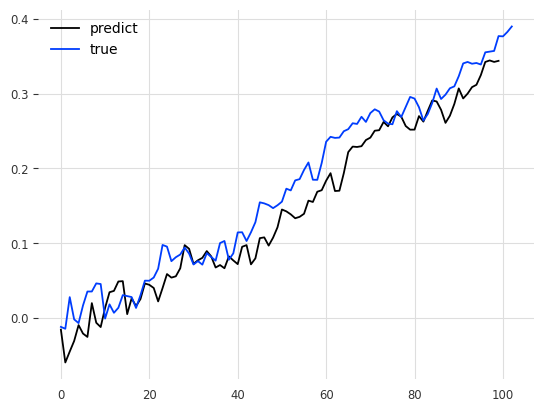

In [267]:
plt.plot(pred_inversed.values().cumsum(), label='predict')
plt.plot(true_inversed[START:].values().cumsum(), label='true')
plt.legend()

error_print(TimeSeries.from_values(true_inversed.values().cumsum()), TimeSeries.from_values(pred_inversed.values().cumsum()))

## BlockRNNModel Standard

In [31]:
try:
  model = BlockRNNModel.load_from_checkpoint("BlockRNNModel_standard", best=True)
except ValueError:
  block_RNN_model = BlockRNNModel(
    input_chunk_length=INPUT_CHUNK,
    output_chunk_length=OUTPUT_CHUNK,
    n_epochs=BLOCK_RNN_EPOCHS,
    model=BLOCK_RNN_MODEL,
    random_state=RANDOM,
    save_checkpoints=True,
    force_reset=RESET,
    model_name="BlockRNNModel_standard",
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0],
      "enable_progress_bar": False,
      "callbacks": [checkpoint]
    }
  )

  block_RNN_model.fit(
    series=train_standard,
    past_covariates=train_standard_cov,
    # future_covariates=train_future_cov,
    val_series=val_standard,
    val_past_covariates=val_standard_cov,
    # val_future_covariates=val_future_cov,
    verbose=False
  )

  model = BlockRNNModel.load_from_checkpoint("BlockRNNModel_standard", best=True)

In [ ]:
block_RNN_model_historical = model.historical_forecasts(
    series=series_standard,
    past_covariates=series_standard_cov,
    # future_covariates=series_future_cov,
    train_length=INPUT_CHUNK+OUTPUT_CHUNK,
    start=START,
    forecast_horizon=OUTPUT_CHUNK,
    stride=OUTPUT_CHUNK,
    retrain=RETRAIN,
    last_points_only=LAST,
    verbose=True,
)

MAPE error is 2.77425 % 
MAE error is 1.62217 % 
R2 error is 0.91066 % 
RMSE error is 1.93125 % 
SMAPE error is 2.81184 %


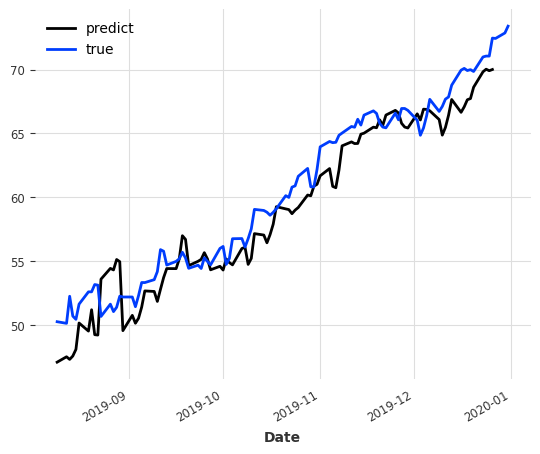

In [33]:
pred_inversed, true_inversed = inverse_func(
    transformer=transformer_standard_target,
    pred=concatenate(block_RNN_model_historical),
    true=series_standard
)

pred_inversed.plot(label='predict')
true_inversed[START:].plot(label='true')

error_print(true_inversed, pred_inversed)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


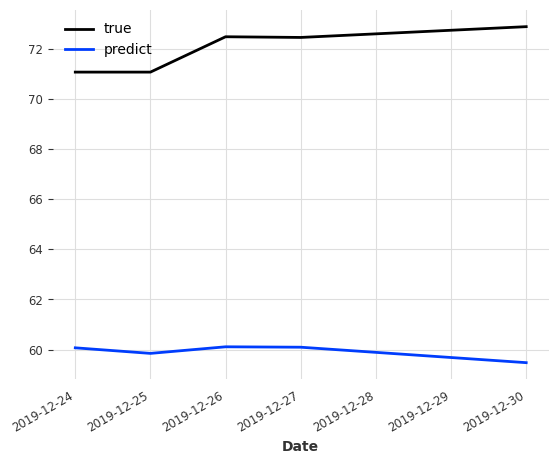

In [34]:
model = BlockRNNModel.load_from_checkpoint("BlockRNNModel_standard", best=True)

prediction = model.predict(
    n=OUTPUT_CHUNK,
    series=val_standard,
    past_covariates=val_standard_cov,
    # future_covariates=val_future_cov,
)

transformer_standard_target.inverse_transform(test_standard)[:OUTPUT_CHUNK].plot(label='true')
transformer_standard_target.inverse_transform(prediction).plot(label='predict')

## Temporal Fusion Transformer

In [23]:
try:
  model = TFTModel.load_from_checkpoint("TFTModel_minmax", best=True)
except ValueError:
  TFT_model = TFTModel(
    input_chunk_length=INPUT_CHUNK,
    output_chunk_length=OUTPUT_CHUNK,
    n_epochs=TFT_EPOCHS,
    random_state=RANDOM,
    save_checkpoints=True,
    force_reset=RESET,
    model_name="TFTModel_minmax",
    pl_trainer_kwargs={
      # "accelerator": "gpu",
      # "devices": [0],
      "enable_progress_bar": False,
      "callbacks": [checkpoint]
    }
  )

  TFT_model.fit(
    series=train_standard,
    past_covariates=train_standard_cov,
    future_covariates=train_future_cov,
    val_series=val_standard,
    val_past_covariates=val_standard_cov,
    val_future_covariates=val_future_cov,
    verbose=False
  )

  model = TFT_model.load_from_checkpoint("TFTModel_minmax", best=True)
  # model = TFT_model

ValueError: Could not find base model save file `_model.pth.tar` in b:\HSE_Masters\darts_logs\TFTModel_minmax.
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
b:\HSE_Masters\.conda\lib\site-packages\pytorch_lightning\trainer\trainer.py:1814: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
b:\HSE_Masters\.conda\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:611: UserWarning: Checkpoint directory b:\HSE_Masters\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


In [ ]:
TFT_model_historical = model.historical_forecasts(
    series=series_minmax,
    past_covariates=series_minmax_cov,
    future_covariates=series_future_cov,
    train_length=INPUT_CHUNK+OUTPUT_CHUNK,
    start=START,
    forecast_horizon=OUTPUT_CHUNK,
    stride=OUTPUT_CHUNK,
    retrain=RETRAIN,
    last_points_only=LAST,
    verbose=True,
)

MAPE error is 3.39749 % 
MAE error is 1.96652 % 
R2 error is 0.81915 % 
RMSE error is 2.74776 % 
SMAPE error is 3.43431 %


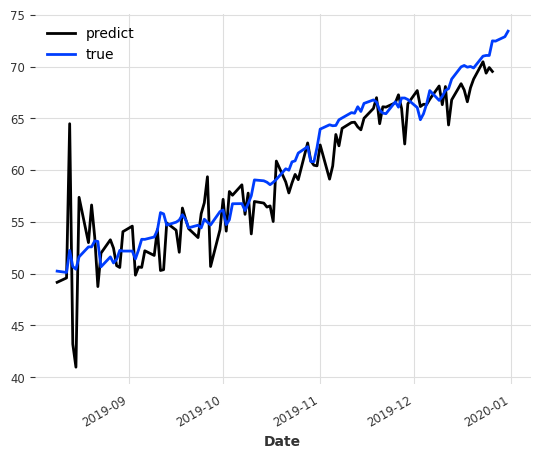

In [26]:
pred_inversed, true_inversed = inverse_func(
    transformer=transformer_minmax_target,
    pred=concatenate(TFT_model_historical),
    true=series_minmax
)

pred_inversed.plot(label='predict')
true_inversed[START:].plot(label='true')

error_print(true_inversed, pred_inversed)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
b:\HSE_Masters\.conda\lib\site-packages\pytorch_lightning\trainer\trainer.py:1814: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


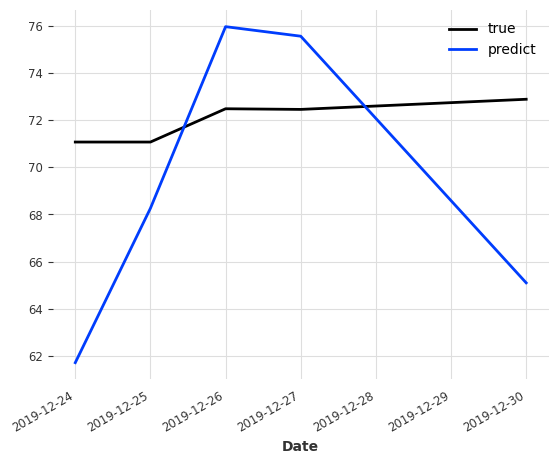

In [28]:
model = TFTModel.load_from_checkpoint("TFTModel_minmax", best=True)

prediction = model.predict(
    n=OUTPUT_CHUNK,
    series=val_minmax,
    past_covariates=val_minmax_cov,
    future_covariates=concatenate([val_future_cov, test_future_cov]),
)

transformer_minmax_target.inverse_transform(test_minmax)[:OUTPUT_CHUNK].plot(label='true')
transformer_minmax_target.inverse_transform(prediction).plot(label='predict')

## Temporal Fusion Transformer 3 days ahead

In [24]:
try:
  model = TFTModel.load_from_checkpoint("TFTModel_minmax_3", best=True)
except ValueError:
  TFT_model = TFTModel(
    input_chunk_length=INPUT_CHUNK,
    output_chunk_length=3,
    n_epochs=TFT_EPOCHS,
    random_state=RANDOM,
    save_checkpoints=True,
    force_reset=RESET,
    model_name="TFTModel_minmax_3",
    pl_trainer_kwargs={
      # "accelerator": "gpu",
      # "devices": [0],
      "enable_progress_bar": False,
      "callbacks": [checkpoint]
    }
  )

  TFT_model.fit(
    series=train_standard,
    past_covariates=train_standard_cov,
    future_covariates=train_future_cov,
    val_series=val_standard,
    val_past_covariates=val_standard_cov,
    val_future_covariates=val_future_cov,
    verbose=False
  )

  model = TFT_model.load_from_checkpoint("TFTModel_minmax_3", best=True)
  # model = TFT_model

ValueError: Could not find base model save file `_model.pth.tar` in b:\HSE_Masters\darts_logs\TFTModel_minmax_3.
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
b:\HSE_Masters\.conda\lib\site-packages\pytorch_lightning\trainer\trainer.py:1814: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
b:\HSE_Masters\.conda\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:611: UserWarning: Checkpoint directory b:\HSE_Masters\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


In [ ]:
TFT_model_historical = model.historical_forecasts(
    series=series_minmax,
    past_covariates=series_minmax_cov,
    future_covariates=series_future_cov,
    train_length=INPUT_CHUNK+OUTPUT_CHUNK,
    start=START,
    forecast_horizon=3, # change
    stride=3, # change
    retrain=RETRAIN,
    last_points_only=LAST,
    verbose=True,
)

MAPE error is 2.37162 % 
MAE error is 1.40708 % 
R2 error is 0.91820 % 
RMSE error is 1.89698 % 
SMAPE error is 2.36575 %


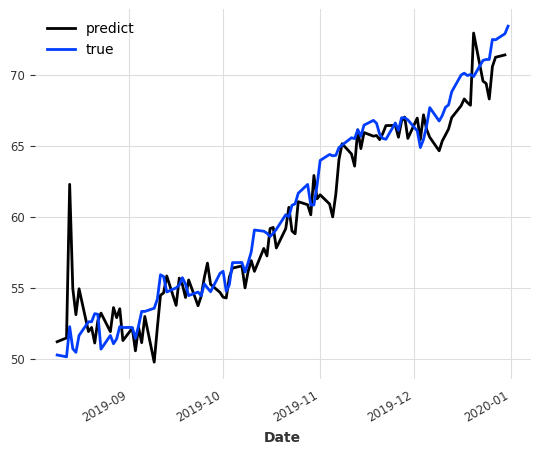

In [26]:
pred_inversed, true_inversed = inverse_func(
    transformer=transformer_minmax_target,
    pred=concatenate(TFT_model_historical),
    true=series_minmax
)

pred_inversed.plot(label='predict')
true_inversed[START:].plot(label='true')

error_print(true_inversed, pred_inversed)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
b:\HSE_Masters\.conda\lib\site-packages\pytorch_lightning\trainer\trainer.py:1814: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


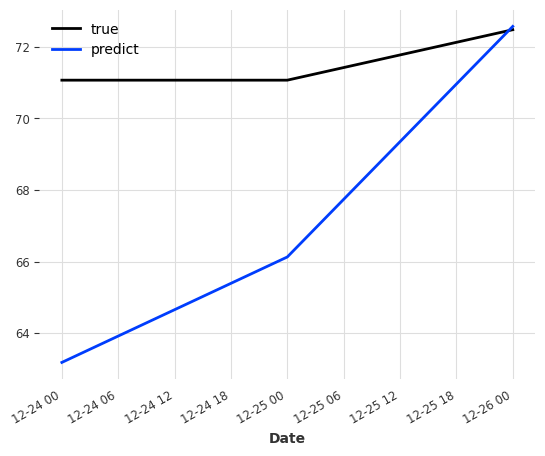

In [29]:
model = TFTModel.load_from_checkpoint("TFTModel_minmax_3", best=True)

prediction = model.predict(
    n=3,
    series=val_minmax,
    past_covariates=val_minmax_cov,
    future_covariates=concatenate([val_future_cov, test_future_cov]),
)

transformer_minmax_target.inverse_transform(test_minmax)[:3].plot(label='true')
transformer_minmax_target.inverse_transform(prediction).plot(label='predict')

# Model SCINet

For the Scinet I used normalization by a max value of stock in a row which is a recomended way for exchange datasets in paper

In [97]:
forecast = pd.read_csv('models/SCINet/predictions/forecast_0.txt', sep=" ", header=None)
forecast = forecast[0] * 180.33

forecast_1 = pd.read_csv('models/SCINet/predictions/forecast_1.txt', sep=" ", header=None)
forecast_1 = forecast_1[0] * 180.33

In [98]:
target = pd.read_csv('models/SCINet/predictions/target_0.txt', sep=" ", header=None)
target = target[0] * 180.33

target_1 = pd.read_csv('models/SCINet/predictions/target_1.txt', sep=" ", header=None)
target_1 = target_1[0] * 180.33

## window_size = 64, horizon = 3, stacks = 2

MAPE error is 2.81836 % 
MAE error is 3.18801 % 
R2 error is 0.97911 % 
RMSE error is 4.24632 % 
SMAPE error is 2.80818 %


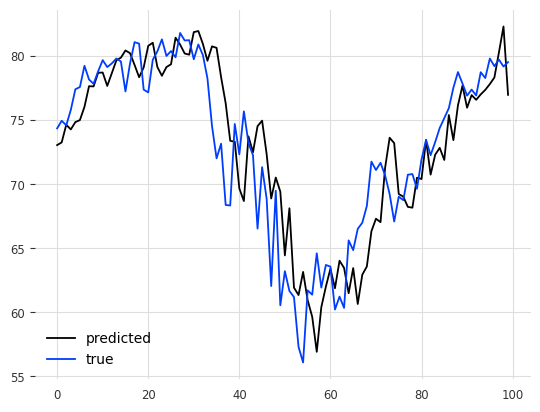

In [99]:
forecast[:100].plot(label='predicted', legend=True)
target[:100].plot(label='true', legend=True)

error_print(TimeSeries.from_series(target), TimeSeries.from_series(forecast))

MAPE error is 1.78117 % 
MAE error is 1.37330 % 
R2 error is -0.05171 % 
RMSE error is 1.74977 % 
SMAPE error is 1.80707 %


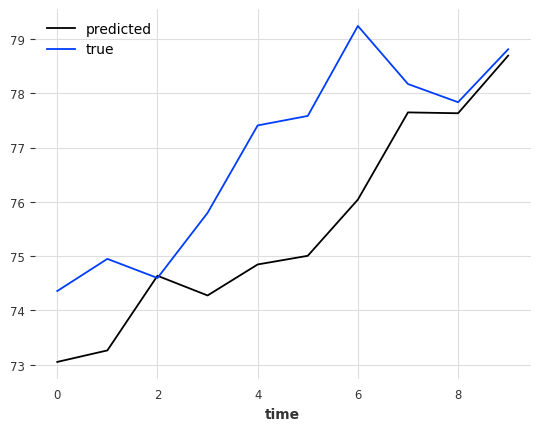

In [105]:
forecast[:10].plot(label='predicted', legend=True)
target[:10].plot(label='true', legend=True)

error_print(TimeSeries.from_series(target[:10]), TimeSeries.from_series(forecast[:10]))

MAPE error is 6.65438 % 
MAE error is 3.90656 % 
R2 error is -1.97482 % 
RMSE error is 4.69158 % 
SMAPE error is 6.34758 %


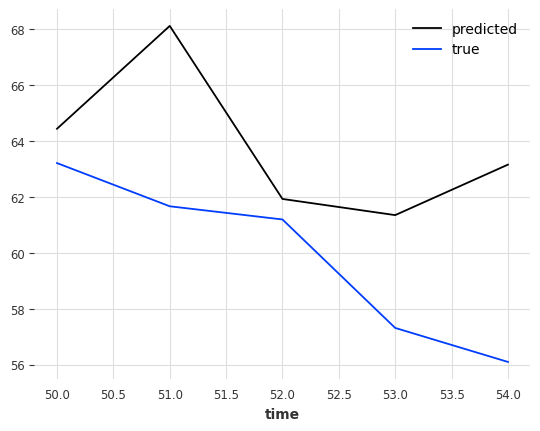

In [107]:
forecast[50:55].plot(label='predicted', legend=True)
target[50:55].plot(label='true', legend=True)

error_print(TimeSeries.from_series(target[50:55]), TimeSeries.from_series(forecast[50:55]))

## window_size = 32, horizon = 3, stacks = 1

MAPE error is 3.85093 % 
MAE error is 4.76284 % 
R2 error is 0.94970 % 
RMSE error is 6.58844 % 
SMAPE error is 3.94050 %


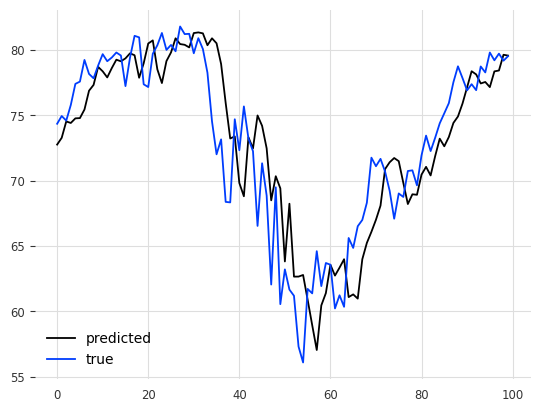

In [100]:
forecast_1[:100].plot(label='predicted', legend=True)
target_1[:100].plot(label='true', legend=True)

error_print(TimeSeries.from_series(target_1), TimeSeries.from_series(forecast_1))

MAPE error is 2.04951 % 
MAE error is 1.58240 % 
R2 error is -0.31557 % 
RMSE error is 1.95700 % 
SMAPE error is 2.08184 %


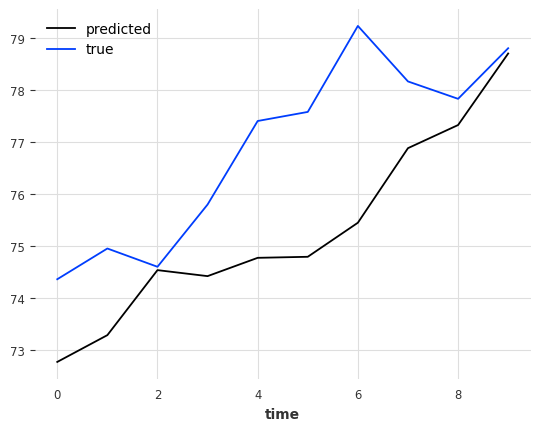

In [108]:
forecast_1[:10].plot(label='predicted', legend=True)
target_1[:10].plot(label='true', legend=True)

error_print(TimeSeries.from_series(target_1[:10]), TimeSeries.from_series(forecast_1[:10]))

MAPE error is 7.05818 % 
MAE error is 4.13883 % 
R2 error is -2.22164 % 
RMSE error is 4.88233 % 
SMAPE error is 6.72597 %


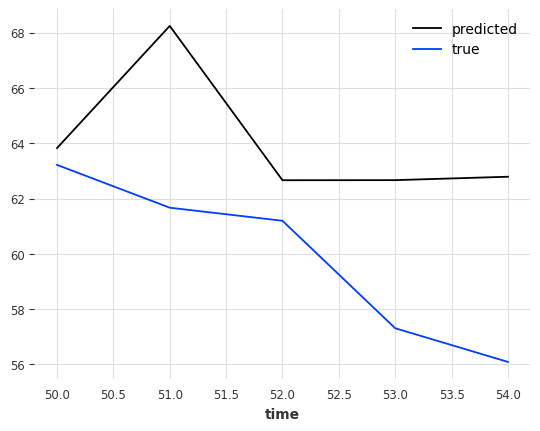

In [109]:
forecast_1[50:55].plot(label='predicted', legend=True)
target_1[50:55].plot(label='true', legend=True)

error_print(TimeSeries.from_series(target_1[50:55]), TimeSeries.from_series(forecast_1[50:55]))